## Measure PPT Values on new simulated dataset

This notebook measures the privacy levels of newly simulated datasets with privacy-preserving technologies, like k-Anonymity, l-Diversity, t-Closeness and Differential Privacy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator

In [2]:
def read_data(meas_dataset):    
    # read csv file
    if meas_dataset == 'diabetes_130':
        orig_df = pd.read_csv('./diabetes_130/diabetic_data.csv')
        dataset_name = 'Diabetes Readmission'
    elif meas_dataset == 'diabetes_012':
        orig_df = pd.read_csv('./diabetes_012/diabetes_012_cleaned.csv')
        dataset_name = 'Diabetes Indicators'
    elif meas_dataset == 'adult':
        orig_df = pd.read_csv('./adult/adult_cleaned.csv')
        dataset_name = 'Adult'


    sim_df_low = pd.read_csv('./'+meas_dataset+'/simulations/low.csv')
    sim_df_medium = pd.read_csv('./'+meas_dataset+'/simulations/medium.csv')
    sim_df_high = pd.read_csv('./'+meas_dataset+'/simulations/high.csv')
    sim_df_maximum = pd.read_csv('./'+meas_dataset+'/simulations/maximum.csv')
    sim_df_westin = pd.read_csv('./'+meas_dataset+'/simulations/westin.csv')
    sim_df_karampela = pd.read_csv('./'+meas_dataset+'/simulations/karampela.csv')

    dataframes = [orig_df, sim_df_low, sim_df_medium, sim_df_high, sim_df_maximum, sim_df_westin, sim_df_karampela]
    names = ['Original', 'Low', 'Medium', 'High', 'Maximum', 'Westin', 'Karampela']

    # select qids
    if meas_dataset == 'diabetes_130':
        qids = ['age', 'weight', 'gender', 'race']
    elif meas_dataset == 'diabetes_012':
        qids = ['Sex', 'Education', 'Age', 'Income']
    elif meas_dataset == 'adult':
        qids = ['age', 'native-country', 'sex', 'relationship']

    return dataframes, names, dataset_name, qids

### k-Anonymity

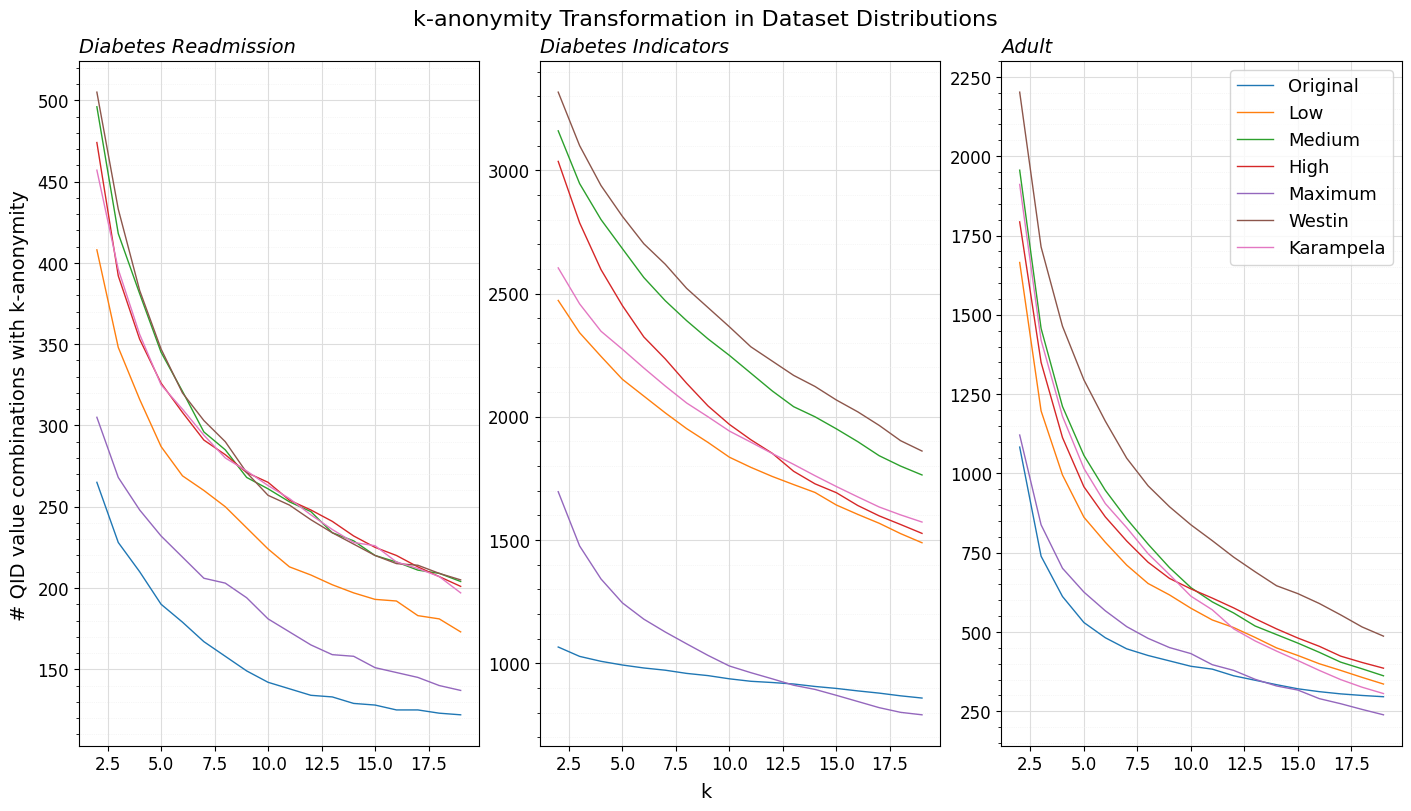

In [5]:
def k_anonymity(meas_dataset, ax):

    dataframes, names, dataset_name, qids = read_data(meas_dataset)  

    k_changes = pd.DataFrame(columns=['k','Original', 'Low', 'Medium', 'High', 'Maximum', 'Westin', 'Karampela'])
    # test k on dataframes
    for k in range(2, 20):
        row = [k]
        for df, name in zip(dataframes, names):
            result = df.groupby(qids).size().sort_values(ascending=False).reset_index(name='count')
            row.append(result[result['count'] >= k].shape[0])
        k_changes.loc[len(k_changes)] = row

    k_changes.plot(x='k', y=names, ax=ax, fontsize=12, linewidth=1)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend().remove()
    ax.set_xlabel('')
    ax.set_title(dataset_name, loc='left', fontstyle='oblique', fontsize=14)

fig = plt.figure(figsize=(14, 8), layout='constrained')
ax_array = fig.subplots(1, 3, squeeze=False, sharey=False, sharex=False)
k_anonymity('diabetes_130', ax_array[0,0])
k_anonymity('diabetes_012', ax_array[0,1])
k_anonymity('adult', ax_array[0,2])
plt.xticks(rotation=0)
plt.legend(fontsize=13)
fig.suptitle('k-anonymity Transformation in Dataset Distributions', fontsize=16)
fig.supylabel('# QID value combinations with k-anonymity', fontsize=14) 
fig.supxlabel('k', fontsize=14)
plt.show()

In [7]:
def k_table(meas_dataset, k, df_results):    
    dataframes, names, dataset_name, qids=read_data(meas_dataset)
    # select qids
    if meas_dataset == 'diabetes_130':
        qids = ['age', 'weight', 'gender', 'race']
    elif meas_dataset == 'diabetes_012':
        qids = ['Sex', 'Education', 'Age', 'Income']
    elif meas_dataset == 'adult':
        qids = ['age', 'native-country', 'sex', 'relationship']

    # test k on dataframes
    row = [dataset_name, k]
    for df in dataframes:
        result = df.groupby(qids).size().sort_values(ascending=False).reset_index(name='count')
        #print(result[result['count'] < k].head(10))
        row.append(result[result['count'] < k].shape[0])
    df_results.loc[len(df_results)] = row

k_changes = pd.DataFrame(columns=['Dataset','k','Original', 'Low', 'Medium', 'High', 'Maximum', 'Westin', 'Karampela'])
k_table('diabetes_130', 7, k_changes)
k_table('diabetes_012', 10, k_changes)
k_table('adult', 3, k_changes)

print(k_changes)


                Dataset   k  Original   Low  Medium  High  Maximum  Westin  \
0  Diabetes Readmission   7       171   301     356   342      200     361   
1   Diabetes Indicators  10       191   835    1212  1453     1080    1250   
2                 Adult   3      2064  2684    2776  2238     1178    2850   

   Karampela  
0        320  
1        897  
2       2699  


## l-diversity and t-closeness

In [8]:
from pycanon import anonymity, report

def l_t(meas_dataset):
    # read csv file
    if meas_dataset == 'diabetes_130':
        orig_df = pd.read_csv('./diabetes_130/diabetic_data.csv')
    elif meas_dataset == 'diabetes_012':
        orig_df = pd.read_csv('./diabetes_012/diabetes_012_cleaned.csv')
    elif meas_dataset == 'adult':
        orig_df = pd.read_csv('./adult/adult_cleaned.csv')


    sim_df_low = pd.read_csv('./'+meas_dataset+'/simulations/low.csv')
    sim_df_medium = pd.read_csv('./'+meas_dataset+'/simulations/medium.csv')
    sim_df_high = pd.read_csv('./'+meas_dataset+'/simulations/high.csv')
    sim_df_maximum = pd.read_csv('./'+meas_dataset+'/simulations/maximum.csv')
    sim_df_westin = pd.read_csv('./'+meas_dataset+'/simulations/westin.csv')
    sim_df_karampela = pd.read_csv('./'+meas_dataset+'/simulations/karampela.csv')

    dataframes = [orig_df, sim_df_low, sim_df_medium, sim_df_high, sim_df_maximum, sim_df_westin, sim_df_karampela]
    names = ['Original', 'Low', 'Medium', 'High', 'Maximum', 'Westin', 'Karampela']
    # select qids
    if meas_dataset == 'diabetes_130':
        qids = ['age', 'weight', 'gender', 'race']
        sa = ['payer_code']
    elif meas_dataset == 'diabetes_012':
        qids = ['Sex', 'Education', 'Age', 'Income']
        sa = ['MentHlth']
    elif meas_dataset == 'adult':
        qids = ['age', 'native-country', 'sex', 'relationship']
        sa = ['occupation']

    for df, name in zip(dataframes, names):
        l = anonymity.l_diversity(df, qids, sa)
        t = anonymity.t_closeness(df, qids, sa)
        print(name,'\n l-diversity:', l, '\n t-closeness:', t)    
        report.print_report(df, qids, sa)

l_t('diabetes_130')
print('-----------------------------------')
l_t('diabetes_012')
print('-----------------------------------')
l_t('adult')

Original 
 l-diversity: 1 
 t-closeness: 0.9946052709156302
c for (c,l)-diversity cannot be calculated as l=1
The dataset verifies:
          	 - k-anonymity with k = 1
          	 - (alpha,k)-anonymity with alpha = 1.0 and k = 1
          	 - l-diversity with l = 1
          	 - entropy l-diversity with l = 1
          	 - (c,l)-diversity with c = nan and l = 1
          	 - basic beta-likeness with beta = 388.9080459770115
          	 - enhanced beta-likeness with beta = 11.530431339099893
          	 - t-closeness with t = 0.9946052709156302
          	 - delta-disclosure privacy with delta = 5.9659109317772
Low 
 l-diversity: 1 
 t-closeness: 0.9986734272743353
c for (c,l)-diversity cannot be calculated as l=1
The dataset verifies:
          	 - k-anonymity with k = 1
          	 - (alpha,k)-anonymity with alpha = 1.0 and k = 1
          	 - l-diversity with l = 1
          	 - entropy l-diversity with l = 1
          	 - (c,l)-diversity with c = nan and l = 1
          	 - basic b

KeyboardInterrupt: 

## Differential Privacy

In [46]:
def read_dfs_dp(dp_df):
    if dp_df == 'diabetes_130':
        orig_df = pd.read_csv('./diabetes_130/diabetic_data.csv')
        column = 'age'
        column_id = 4
        epsilon = 0.3
    elif dp_df == 'diabetes_012':
        orig_df = pd.read_csv('./diabetes_012/diabetes_012_cleaned.csv')
        column = 'Age'
        column_id = 19
        epsilon = 0.1
    elif dp_df == 'adult':
        orig_df = pd.read_csv('./adult/adult_cleaned.csv')
        column = 'age'
        column_id = 0
        epsilon = 1

    sim_df_low = pd.read_csv('./'+dp_df+'/simulations/low.csv')
    sim_df_medium = pd.read_csv('./'+dp_df+'/simulations/medium.csv')
    sim_df_high = pd.read_csv('./'+dp_df+'/simulations/high.csv')
    sim_df_maximum = pd.read_csv('./'+dp_df+'/simulations/maximum.csv')
    sim_df_westin = pd.read_csv('./'+dp_df+'/simulations/westin.csv')
    sim_df_karampela = pd.read_csv('./'+dp_df+'/simulations/karampela.csv')

    dataframes = [orig_df, sim_df_low, sim_df_medium, sim_df_high, sim_df_maximum, sim_df_westin, sim_df_karampela]

    return dataframes, column, column_id, epsilon

def create_neighbor(df, column_id):
    ids = np.random.choice(df.index, size=2, replace=False)
    neighbor1 = df.copy()
    neighbor2 = df.copy()
    if neighbor1.iloc[ids[0], column_id]==neighbor2.iloc[ids[1], column_id]:
        neighbor2.iloc[ids[1], column_id] = '[0-100)'


    return neighbor1, neighbor2

def column_counts(df, column):
    counts = df[column].value_counts()
    return counts

In [ ]:
dp_df = 'diabetes_012'
dataframes, column, column_id, epsilon = read_dfs_dp(dp_df)
for df in dataframes:
    neighbor1, neighbor2 = create_neighbor(df, column_id)
    counts1 = column_counts(neighbor1, column)
    counts2 = column_counts(neighbor2, column)
    
    print("Counts in neighbor1:\n", counts1)
    print("Counts in neighbor2:\n", counts2)

    prob1 = counts1 / counts1.sum()
    prob2 = counts2 / counts2.sum()
    print('e^epsilon =',np.exp(epsilon))
    for value in prob1.index:
        p1 = prob1.get(value, 0)
        p2 = prob2.get(value, 0)
        ratio = p1 / (p2 + 1e-10)
        if ratio > np.exp(epsilon):
            print("failed to fulfil dp requirement", np.exp(epsilon))
        else:
            print(f"Ratio for value {value}: {ratio}")
    print('-----------------------------------')
